# Create Occlusion datasets

In [1]:
import os
import my_common_modules as my_modules
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import json
from math import sqrt,pi,cos,sin
from PIL import Image
import cv2
import itertools

#Plant list
plant_names = ["Sugarbeat","Capsella","Galium"]

## Load in single plants datasets

In [2]:
def getShuffledPlants(smallest_set=359):
    # Load in backgrounds
    image_filepaths = []
    label_filepaths = []
    color_filepaths = []
    meta_filepaths = []

    data_dirs = ['.\\data\\sugarbeat_cleaned\\','.\\data\\capsella_cleaned\\','.\\data\\galium_cleaned\\']

    for data_dir in data_dirs:
        add_image_filepaths,add_label_filepaths,add_color_filepaths,add_meta_filepaths = my_modules.import_dataset_filepaths("png","png","json", data_dir)
        add_count = len(add_image_filepaths)
        if add_count > smallest_set:
            samples = list(zip(add_image_filepaths,add_label_filepaths,add_color_filepaths,add_meta_filepaths))
            samples = random.sample(samples,smallest_set)
            add_image_filepaths,add_label_filepaths,add_color_filepaths,add_meta_filepaths = zip(*samples)
        image_filepaths += add_image_filepaths
        label_filepaths += add_label_filepaths
        color_filepaths += add_color_filepaths
        meta_filepaths += add_meta_filepaths
    sample_filepaths = list(zip(image_filepaths,label_filepaths,color_filepaths,meta_filepaths))
    random.shuffle(sample_filepaths)
    plant_data_bundles = []
    for plant_data_bundle in sample_filepaths:
        plant_data_bundles.append(plant_data_bundle)
    
    return plant_data_bundles

## Add plant function

In [3]:
def checkNewPlantOcclusion(instance_mask,radius_mask,new_radius_mask,new_plant_id):
    #1. Calculate pixels per plant instance within crop
    #1a. For existing plants
    num_plants = new_plant_id-1
    plant_px = np.zeros(new_plant_id)
    for plant_id in range(1,num_plants+1):
        plant_px[plant_id-1] = np.sum(instance_mask == plant_id)
    #1b. For new plant
    plant_px[-1] = round(np.sum(new_radius_mask)/np.max(new_radius_mask))
    
    #2. Compare radii per pixel
    new_plant_pixel_added = (radius_mask < new_radius_mask).astype('int')
    existing_plant_pixel_kept = (radius_mask >= new_radius_mask)
    
    #3. Set instance values occluded by new plant to zero
    remaining_original_px = np.multiply(instance_mask,existing_plant_pixel_kept)
    
    #4. Calculate newly occluded pixels
    lost_px = np.zeros(num_plants+1,dtype='int')
    for plant_id in range(1,num_plants+1):
        lost_px[plant_id-1] = plant_px[plant_id-1] - np.sum(remaining_original_px == plant_id)
    lost_px[-1] = plant_px[-1] - np.sum(new_plant_pixel_added)
        
    return lost_px,new_plant_pixel_added,existing_plant_pixel_kept

In [4]:
def addPlant(img_data_bundle,new_plant_data_bundle_list,occlusion_percent=0,new_location_chance = 0.33,debug_level = 0):
    
    if debug_level > 0:
        print("Debug level > 1")
        MAX_TRIES = 20
        POINTS_ON_LINE = 5
    else:
        MAX_TRIES = 20
        POINTS_ON_LINE = 20
    
    img,lbl,col_lbl,plant_instances,bboxes,stem_mask = img_data_bundle
    plant_id_mask,plant_size_mask,plant_details = plant_instances
    
    rows = np.shape(img)[0]
    cols = np.shape(img)[1]
    
    for (new_plant_img,new_plant_lbl,new_plant_col_lbl,new_stem) in new_plant_data_bundle_list:
        new_plant_species = np.max(new_plant_lbl)
        new_plant_lbl_mask = (new_plant_lbl >= 1).astype('int')
        new_plant_pixels = np.sum(new_plant_lbl_mask)
        new_plant_details = [new_plant_pixels,0]
        plant_details.append(new_plant_details)
        new_plant_id = len(plant_details)
        radius_new = round(np.shape(new_plant_img)[0]/2)
        new_radius_mask = new_plant_lbl_mask*radius_new
        foundGoodSpot = False
        # If plant to be added for occlusion
        if (random.random()>=new_location_chance) and (len(bboxes) > 0):
            for try_num in range(MAX_TRIES):
                if debug_level > 0:
                    theta = pi/2
                    bbox = bboxes[0]
                else:
                    theta = random.uniform(-pi,pi)
                    bbox = random.choice(bboxes)
                
                plant_id = int(bbox['plant_id'])
                radius = int(bbox['bndcircle']['radius'])
                center = bbox['bndcircle']['center']
                dmax = radius + radius_new
                count = 0
                for try_d in np.arange(dmax/POINTS_ON_LINE,dmax,dmax/POINTS_ON_LINE):
                    center_new = (int((try_d+radius_new)*cos(theta)+center[0]),int((try_d+radius_new)*sin(theta)+center[1]))
                    xmin = round(center_new[0]-radius_new)
                    ymin = round(center_new[1]-radius_new)
                    xmax = round(center_new[0]+radius_new)
                    ymax = round(center_new[1]+radius_new)
                    # check if out of bounds
                    if ((xmin<0)or(ymin<0)or(xmax>=cols)or(ymax>=rows)):
                        continue
                    foundGoodSpot = True
                    # add new plant to background crop
                    losses, new_plant_pix_vis, existing_plant_pixel_kept = checkNewPlantOcclusion(plant_id_mask[ymin:ymax,xmin:xmax],plant_size_mask[ymin:ymax,xmin:xmax],new_radius_mask,new_plant_id)
                    plant1_occlusion = (plant_details[plant_id-1][1] + losses[plant_id-1])/plant_details[plant_id-1][0]
                    plant2_occlusion = losses[-1]/plant_details[-1][0]
                    count += 1
                    for i in range(np.shape(losses)[0]):
                        original_px = plant_details[i][0]
                        occluded_px = plant_details[i][1] + losses[i]
                        new_occlusion_pcnt = occluded_px/original_px
                        if ((new_occlusion_pcnt > (occlusion_percent+0.05)) or ((plant1_occlusion < (occlusion_percent-0.05)) and (plant2_occlusion < (occlusion_percent-0.05)))):
                            foundGoodSpot = False
                    
                    if foundGoodSpot:
                        # Update pixels
                        #1. Remove occluded pixels from new plant using new_plant_pix_vis
                        new_plant_lbl = np.multiply(new_plant_pix_vis,new_plant_lbl)
                        for c in range(3):
                            new_plant_img[:,:,c] = np.multiply(new_plant_pix_vis,new_plant_img[:,:,c])
                            new_plant_col_lbl[:,:,c] = np.multiply(new_plant_pix_vis,new_plant_col_lbl[:,:,c])
                        
                        #2. Set pixels in original image to be replaced to zero
                        #img,lbl,col_lbl,plant_instances,bboxes
                        lbl[ymin:ymax,xmin:xmax] = np.multiply(lbl[ymin:ymax,xmin:xmax],existing_plant_pixel_kept.astype('int'))
                        plant_id_mask[ymin:ymax,xmin:xmax] = np.multiply(plant_id_mask[ymin:ymax,xmin:xmax],existing_plant_pixel_kept.astype('int'))
                        plant_size_mask[ymin:ymax,xmin:xmax] = np.multiply(plant_size_mask[ymin:ymax,xmin:xmax],existing_plant_pixel_kept.astype('int'))
                        for c in range(3):
                            img[ymin:ymax,xmin:xmax,c] = np.multiply(img[ymin:ymax,xmin:xmax,c],existing_plant_pixel_kept.astype('int'))
                            col_lbl[ymin:ymax,xmin:xmax,c] = np.multiply(col_lbl[ymin:ymax,xmin:xmax,c],existing_plant_pixel_kept.astype('int'))
                            
                        #3. Add new plant pixels to blackened out original image
                        lbl[ymin:ymax,xmin:xmax] = lbl[ymin:ymax,xmin:xmax]+new_plant_lbl
                        img[ymin:ymax,xmin:xmax,:] = img[ymin:ymax,xmin:xmax,:]+new_plant_img
                        col_lbl[ymin:ymax,xmin:xmax,:] = col_lbl[ymin:ymax,xmin:xmax,:]+new_plant_col_lbl
                        plant_id_mask[ymin:ymax,xmin:xmax] = plant_id_mask[ymin:ymax,xmin:xmax]+new_plant_id*new_plant_pix_vis.astype('int')
                        plant_size_mask[ymin:ymax,xmin:xmax] = plant_size_mask[ymin:ymax,xmin:xmax]+radius_new*new_plant_pix_vis.astype('int')
                        stem_mask[ymin+int(new_stem["y"]),xmin+int(new_stem["x"])] = int(new_plant_species)
                        
                        #4. Update plant details
                        for i in range(new_plant_id):
                            plant_details[-i][1] += losses[i]
                            
                        
                        #5. Update bboxes
                        xmin_bbox = xmin
                        ymin_bbox = ymin
                        xmax_bbox = xmin+2*radius_new-1
                        ymax_bbox = ymin+2*radius_new-1
                        for x in range(0,radius_new):
                            if np.sum(new_plant_lbl[:,x])>0:
                                xmin_bbox = xmin+x
                                break
                        for x in range(2*radius_new-1,radius_new,-1):
                            if np.sum(new_plant_lbl[:,x])>0:
                                xmax_bbox = xmin+x
                                break
                        for y in range(0,radius_new):
                            if np.sum(new_plant_lbl[y,:])>0:
                                ymin_bbox = ymin+y
                                break
                        for y in range(2*radius_new-1,radius_new,-1):
                            if np.sum(new_plant_lbl[y,:])>0:
                                ymax_bbox = ymin+y
                                break
                                
                        bbox = {
                            "plant_id":int(new_plant_id),
                            "inserted":True,
                            "species_id":int(new_plant_species),
                            "plant_name":plant_names[new_plant_species-1],
                            "original_pixels":int(new_plant_pixels),
                            "occluded_pixels":int(0),
                            "stem":{"x":xmin+int(new_stem["x"]),
                                    "y":ymin+int(new_stem["y"])
                            },
                            "bndbox":{
                                "xmin":int(xmin_bbox),
                                "ymin":int(ymin_bbox),
                                "xmax":int(xmax_bbox),
                                "ymax":int(ymax_bbox)
                            },
                            "bndcircle":{
                                "center":center_new,
                                "radius":int(radius_new)
                            }
                        }
                        bboxes.append(bbox)
                        bbox_count = 0
                        for bbox in bboxes:
                            bbox['occluded_pixels'] = int(bbox['occluded_pixels'] + losses[bbox_count])
                            bbox_count += 1
                        break
                        
                if foundGoodSpot:
                    break
        
        if not(foundGoodSpot): # place randomly
            # First block out current bounding boxes
            original_occupation_mask = np.zeros([rows,cols])
            for bbox in bboxes:
                bndbox = bbox['bndbox']
                xmin = int(bndbox['xmin'])
                ymin = int(bndbox['ymin'])
                xmax = int(bndbox['xmax'])
                ymax = int(bndbox['ymax'])
                cv2.rectangle(original_occupation_mask,(xmin,ymin),(xmax,ymax),1,-1)
            
            w = np.shape(new_plant_img)[1]
            h = np.shape(new_plant_img)[0]
            if debug_level > 0:
                print("[h,w]=["+str(h)+","+str(w)+"]")
                print("Occupation Mask:")
                print(original_occupation_mask)
            # start randomly trying
            for try_num in range(3*MAX_TRIES):
                rand_xmin = random.randint(0, cols-w)
                rand_ymin = random.randint(0, rows-h)
                trial_occupation_mask = original_occupation_mask[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w] + np.ones([h,w])
                if debug_level > 0:
                    print("tring position: [" + str(rand_ymin)+","+str(rand_xmin)+"]")
                    print(trial_occupation_mask)
                if np.sum((trial_occupation_mask == 2).astype('int')) == 0: #if there is no overlap
                    foundGoodSpot = True
                    break
            
            if foundGoodSpot:
                #1. blacken out original pixels
                original_pixels_obscured = np.invert(new_plant_lbl_mask.astype(np.bool)).astype('int')
                lbl[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w] = np.multiply(original_pixels_obscured,lbl[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w])
                plant_id_mask[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w] = np.multiply(original_pixels_obscured.astype('int'),plant_id_mask[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w])
                plant_size_mask[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w] = np.multiply(original_pixels_obscured.astype('int'),plant_size_mask[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w])
                for c in range(3):
                    img[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w,c] = np.multiply(original_pixels_obscured,img[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w,c])
                    col_lbl[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w,c] = np.multiply(original_pixels_obscured,col_lbl[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w,c])

                #2. add new plant to original image
                img[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w,:] += new_plant_img
                lbl[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w,] += new_plant_lbl
                col_lbl[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w,:] += new_plant_col_lbl
                plant_id_mask[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w] += (new_plant_lbl_mask.astype('int')*new_plant_id)
                plant_size_mask[rand_ymin:rand_ymin+h,rand_xmin:rand_xmin+w] += (new_plant_lbl_mask.astype('int')*radius_new)
                stem_mask[rand_ymin+int(new_stem["y"]),rand_xmin+int(new_stem["x"])] = int(new_plant_species)
                
                #3. Update bboxes
                plant_outline = (plant_id_mask == new_plant_id).astype('uint8')
                #plt.figure(figsize=(12,12))
                #plt.imshow((plant_outline*250).astype('uint8'))
                #plt.show()
                ret,thresh = cv2.threshold(plant_outline,0,255,0)
                contours,hierarchy = cv2.findContours(thresh, 1, 2)
                biggestarea = 0
                for cnt in contours:
                    area = cv2.contourArea(cnt)
                    if area > biggestarea:
                        biggestcnt = cnt
                x_bbox,y_bbox,w_bbox,h_bbox = cv2.boundingRect(biggestcnt)
                
                center_new = (round(rand_xmin+w/2),round(rand_ymin+h/2))
                bbox = {
                    "plant_id":int(new_plant_id), 
                    "inserted":True,
                    "species_id":int(new_plant_species),
                    "plant_name":plant_names[new_plant_species-1],
                    "original_pixels":int(new_plant_pixels),
                    "occluded_pixels":int(0),
                    "bndbox":{
                        "xmin":int(x_bbox),
                        "ymin":int(y_bbox),
                        "xmax":int(x_bbox+w_bbox),
                        "ymax":int(y_bbox+h_bbox)
                    },
                    "bndcircle":{
                        "center":center_new,
                        "radius":int(radius_new)
                    }
                }
                bboxes.append(bbox)
        if not(foundGoodSpot):
            plant_details.pop()
        
    img_data_bundle = (img,lbl,col_lbl,plant_instances,bboxes,stem_mask)
    return img_data_bundle

## Create test cases

In [5]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_NEAREST)
  return result

# Making background
plant_color = 170
lbl = np.zeros([8,8],dtype='int')
lbl[0,1:7] = 1
lbl[1,2:6] = 1
lbl[2,4] = 1
lbl[2:4,2:4] = 2

img = np.zeros([8,8,3],dtype='uint8')
col_lbl = np.zeros([8,8,3],dtype='uint8')
img[:,:,1] = (lbl*plant_color).astype('uint8')
img[2:4,2:4,1] = plant_color
col_lbl[:,:,0] = (lbl*255).astype('uint8')
col_lbl[2:4,2:4,0] = 255

new_plant_lbl = np.ones([4,4],dtype='int')
new_plant_lbl[1,1] = 0
new_plant_lbl[3,:] = 0
new_plant_lbl[:,0] = 0
new_plant_lbl[:,3] = 0
new_plant_img = np.zeros([4,4,3],dtype='uint8')
new_plant_col_lbl = np.zeros([4,4,3],dtype='uint8')
new_plant_img[:,:,1] = (new_plant_lbl*plant_color).astype('uint8')
new_plant_col_lbl[:,:,0] = (new_plant_lbl*255).astype('uint8')
original_pixels = np.sum(new_plant_lbl)

bboxes = []
bbox1 = {
    "plant_id":1,
    "inserted":False,
    "species_id":1,
    "plant_name":"Sugarbeat",
    "original_pixels":22,
    "occluded_pixels":0,
    "bndbox":{
        "xmin":1,
        "ymin":0,
        "xmax":7,
        "ymax":2},
    "bndcircle":{
        "center":(4,-1),
        "radius":3
    }
}
bboxes.append(bbox1)
bbox2 = {
    "plant_id":2,
    "inserted":False,
    "species_id":1,
    "plant_name":"Sugarbeat",
    "original_pixels":4,
    "occluded_pixels":0,
    "bndbox":{
        "xmin":2,
        "ymin":2,
        "xmax":3,
        "ymax":3},
    "bndcircle":{
        "center":(3,3),
        "radius":1
    }
}
bboxes.append(bbox2)

plant_details = []
plant_details.append([22,0])
plant_details.append([4,0])
radius_mask = 3*lbl.copy()
radius_mask[2:4,2:4] = 1
print("lbl:")
print(lbl)
print("radius_mask:")
print(radius_mask)
plant_instances = (lbl.copy(),radius_mask,plant_details)

#bundle up images
#img_data_bundle = (img,lbl,col_lbl,plant_instances,bboxes,stem_mask)
#new_plant_data_bundle_list = []
#new_plant_data_bundle_list.append((new_plant_img,new_plant_lbl,new_plant_col_lbl))

#img_data_bundle = addPlant(img_data_bundle,new_plant_data_bundle_list,occlusion_percent=0.2,new_location_chance = 1,debug_level = 2)

lbl:
[[0 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 0 0]
 [0 0 2 2 1 0 0 0]
 [0 0 2 2 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
radius_mask:
[[0 3 3 3 3 3 3 0]
 [0 0 3 3 3 3 0 0]
 [0 0 1 1 3 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


## Create synthetic images

951
{'Background': '0741'}
toFlip: 1
Flipping
Percent cover: [1.3,0.0,0.6]
lbl max: 3


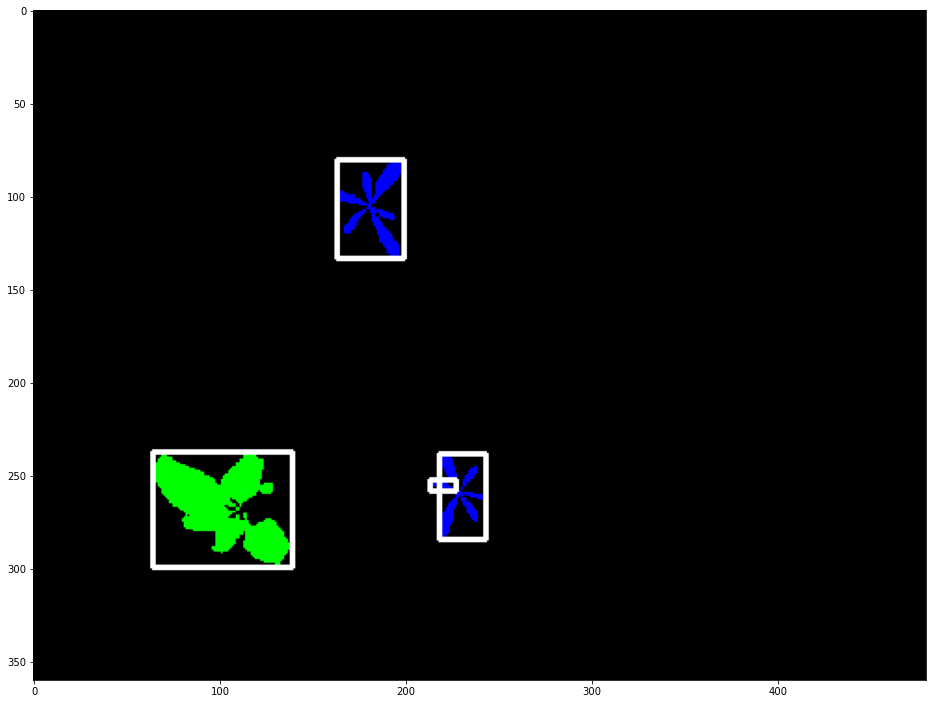

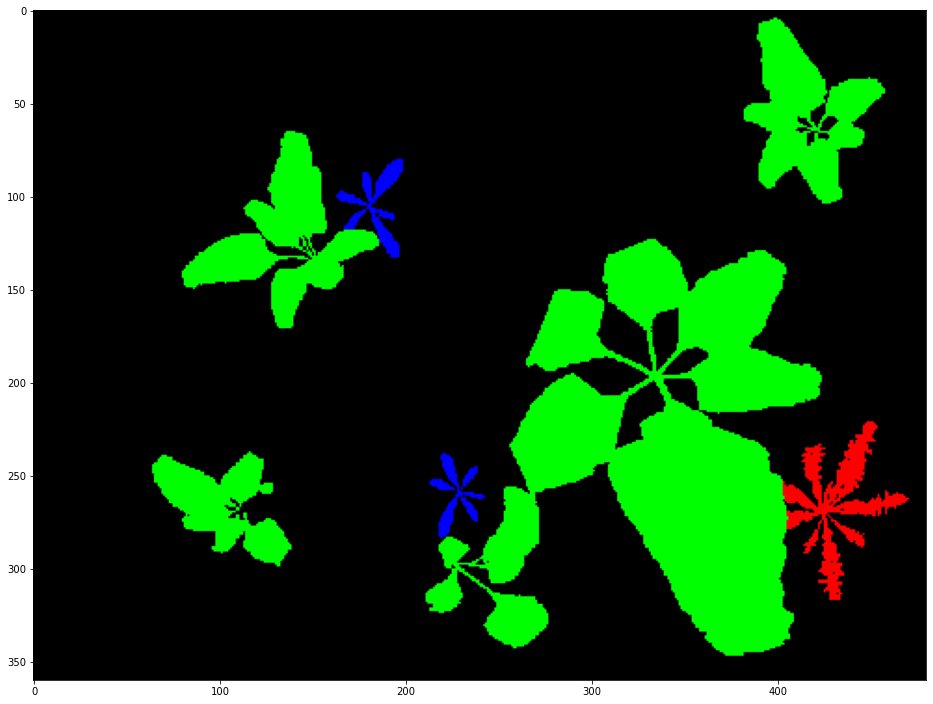

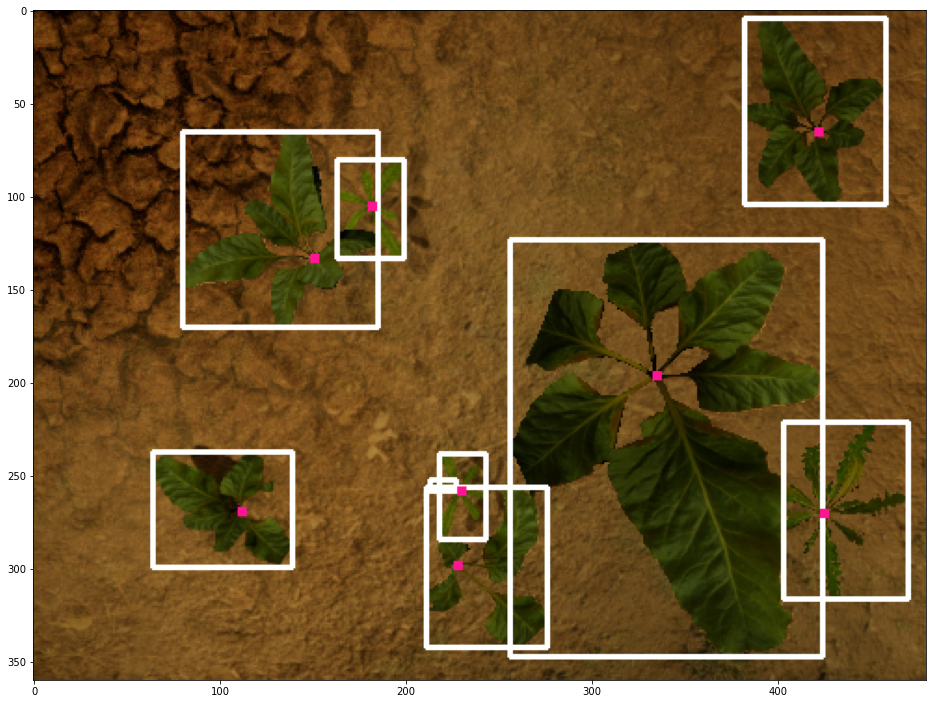

In [6]:


# Load in backgrounds
data_dir = '.\\data\\backgrounds_cleaned\\'
bkgr_image_filepaths,bkgr_label_filepaths,bkgr_color_filepaths,bkgr_meta_filepaths = my_modules.import_dataset_filepaths("png","png", "json",data_dir)
bkgr_count = len(bkgr_image_filepaths)
print(bkgr_count)
seed = 123
random.seed(seed)
bkgr_image_samples = random.sample(bkgr_image_filepaths,3)
random.seed(seed)
bkgr_label_samples = random.sample(bkgr_label_filepaths,3)
random.seed(seed)
bkgr_color_samples = random.sample(bkgr_color_filepaths,3)
random.seed(seed)
bkgr_meta_samples = random.sample(bkgr_meta_filepaths,3)

bkgr_image_samples = [".\\data\\backgrounds_cleaned\\rgb\\0741.png"]
bkgr_label_samples = [".\\data\\backgrounds_cleaned\\gt\\0741.png"]
bkgr_color_samples = [".\\data\\backgrounds_cleaned\\gt_color\\0741.png"]
bkgr_meta_samples = [".\\data\\backgrounds_cleaned\\meta\\0741.json"]

metadata = []
rows = 360
cols = 480
cx = cols/2
cy = rows/2
total_pix = rows * cols
sample_cnt = 1

sugarbeat_pct = 0
capsella_pct = 0
galium_pct = 0
random.seed(seed)
new_plant_data_bundles = getShuffledPlants()
for (lbl_path,col_lbl_path,img_path,meta_path) in zip(bkgr_label_samples,bkgr_color_samples,bkgr_image_samples,bkgr_meta_samples):
    lbl = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE)
    col_lbl = cv2.imread(col_lbl_path)
    img = cv2.imread(img_path)
    meta = {"Background":lbl_path[-8:-4]}
    print(meta)
    
    # should background be flipped?
    toFlip = random.choice([0, 1])
    print("toFlip: " + str(toFlip))
    meta["Background_flipped"] = toFlip
    meta_json = open(meta_path)
    stem_meta = json.load(meta_json)
    meta_json.close()
    stem = stem_meta["stem"]
    if toFlip:
        print("Flipping")
        lbl = cv2.flip(lbl,1) # Horizontal flip left to right
        col_lbl = cv2.flip(col_lbl,1)
        img = cv2.flip(img,1)
        if stem is not None:
            stem_xs = stem["x"]
            for i in range(len(stem_xs)):
                stem_xs[i] = int(2*cx - stem_xs[i])
            stem["x"] = stem_xs
    
    # Pixel break-down of background image
    sugarbeat_mask = (lbl == 1)
    capsella_mask = (lbl == 2)
    galium_mask = (lbl == 3)
    sugarbeat_pct = round(100*np.sum(sugarbeat_mask)/total_pix,1)
    capsella_pct = round(100*np.sum(capsella_mask)/total_pix,1)
    galium_pct = round(100*np.sum(galium_mask)/total_pix,1)
    print("Percent cover: [" + str(sugarbeat_pct) + "," + str(capsella_pct) + "," + str(galium_pct) + "]")
    
    # Bounding boxes for background
    bboxes = []
    white_mask = (lbl > 0)
    contours,hierarchy = cv2.findContours(white_mask.astype('uint8'), 0, 2)
    bboxid = 1
    col_output = col_lbl.copy()
    plant_id_mask = np.zeros([rows,cols],dtype='int')
    radius_mask = np.zeros([rows,cols],dtype='int')
    stem_mask = np.zeros([rows,cols],dtype='int')
    plant_details = []
    for cnt in contours:
        
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(col_output,(x,y),(x+w,y+h),(255,255,255),2)
        (cir_x,cir_y),radius = cv2.minEnclosingCircle(cnt)
        center = (int(cir_x),int(cir_y))
        radius = int(radius)
        cv2.drawContours(plant_id_mask,[cnt],0,bboxid,-1)
        cv2.drawContours(radius_mask,[cnt],0,radius,-1)
        plant_id = np.max(lbl[y:y+h,x:x+w])
        area = cv2.contourArea(cnt)
        plant_details.append([area,0])
        stem_xs = stem["x"]
        stem_ys = stem["y"]
        stem_x = 0
        stem_y = 0
        for i in range(len(stem_xs)):
            stem_x = int(stem_xs[i])
            stem_y = int(stem_ys[i])
            if ((stem_x > x) and (stem_x < (x+w)) and (stem_y > y) and (stem_y < (y+h))):
                break
        if ((stem_x == 0) and (stem_y == 0)):
            print("WARNING: Stem not in bounding box!!!")

        stem_mask[stem_y,stem_x] = plant_id
        bbox = {
            "plant_id":bboxid,
            "inserted":False,
            "species_id":plant_id,
            "plant_name":plant_names[plant_id-1],
            "original_pixels":area,
            "occluded_pixels":0,
            "stem":{
                "x":int(stem_x),
                "y":int(stem_y)
            },
            "bndbox":{
                "xmin":x,
                "ymin":y,
                "xmax":x+w,
                "ymax":y+h},
            "bndcircle":{
                "center":center,
                "radius":radius
            }
        }
        bboxes.append(bbox)
        
    # Display background color label with bboxes
    plt.figure(figsize=(16,16))
    plt.imshow(cv2.cvtColor(col_output, cv2.COLOR_BGR2RGB))
    
    # Bundle Background image files together
    plant_instances = (plant_id_mask,radius_mask,plant_details)
    img_data_bundle = (img,lbl,col_lbl,plant_instances,bboxes, stem_mask) 
    
    # Add synthetic images
    new_plants_added = random.randint(5,12) # How many new plants to add
    new_plant_data_bundle_list = []
    area_array = np.zeros(new_plants_added)
    for i in range(new_plants_added):
        new_plant_filepaths = new_plant_data_bundles.pop()
        new_img = cv2.imread(new_plant_filepaths[0])
        new_lbl = cv2.imread(new_plant_filepaths[1], cv2.IMREAD_GRAYSCALE)
        new_col_lbl = cv2.imread(new_plant_filepaths[2])
        meta_json = open(new_plant_filepaths[3])
        stem_meta = json.load(meta_json)
        meta_json.close()
        new_stem = stem_meta["stem"]
        area = np.sum((new_lbl > 0).astype('int'))
        area_array[i] = area
        new_plant_data_bundle_list.append((new_img,new_lbl,new_col_lbl,new_stem))
        
    sorted_images = np.flip(np.argsort(area_array))
    sorted_plant_data_bundle_list = []
    for i in range(new_plants_added):
        sorted_plant_data_bundle_list.append(new_plant_data_bundle_list[sorted_images[i]])
        
    
    img_data_bundle = addPlant(img_data_bundle,sorted_plant_data_bundle_list,occlusion_percent=0.20,new_location_chance = 0.2)
    #plt.figure(figsize=(16,16))
    img = img_data_bundle[0]
    lbl = img_data_bundle[1]
    print("lbl max: "+ str(np.max(lbl)))
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(cv2.cvtColor(img_data_bundle[2], cv2.COLOR_BGR2RGB))
    plt.show()
    
    stem_mask = img_data_bundle[5]
    for bbox in img_data_bundle[4]:
        bndbox = bbox["bndbox"]
        xmin = bndbox["xmin"]
        ymin = bndbox["ymin"]
        xmax = bndbox["xmax"]
        ymax = bndbox["ymax"]
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,255),2)
    
    for m in range(rows):
        for n in range(cols):
            if stem_mask[m,n]>0:
                img[m-2:m+3,n-2:n+3,0] = 147
                img[m-2:m+3,n-2:n+3,1] = 20
                img[m-2:m+3,n-2:n+3,2] = 255
    plt.figure(figsize=(16,16))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plant_instances = img_data_bundle[3]
    plant_id_mask = plant_instances[0]
    
    
    
    plant_id_mask = (plant_id_mask * 235/np.max(plant_id_mask)).astype('uint8')
    #print(np.shape(plant_id_mask))
    #plt.figure(figsize=(16,16))
    #plt.imshow(plant_id_mask,cmap='turbo')
    #plt.show()
    
    #plt.show()
    
    
    sample_cnt += 1

    


## Generate and save the datasets

In [7]:
# Load in backgrounds
SAVE_IMAGES = True
OCCLUSION_PERCENT = 0.0
if OCCLUSION_PERCENT < 0.01:
    NEW_LOCATION_CHANCE = 1.0
else:
    NEW_LOCATION_CHANCE = 0.2
data_dir = '.\\data\\backgrounds_cleaned\\'
bkgr_image_filepaths,bkgr_label_filepaths,bkgr_color_filepaths,bkgr_meta_filepaths = my_modules.import_dataset_filepaths("png","png","json", data_dir)
bkgr_image_filepaths = bkgr_image_filepaths + bkgr_image_filepaths
bkgr_label_filepaths = bkgr_label_filepaths + bkgr_label_filepaths
bkgr_color_filepaths = bkgr_color_filepaths + bkgr_color_filepaths
bkgr_meta_filepaths = bkgr_meta_filepaths + bkgr_meta_filepaths

bkgr_count = len(bkgr_image_filepaths)
print(bkgr_count)
seed = 123
random.seed(seed)

TOTAL_IMAGES = 1900

bkgr_image_samples = random.sample(bkgr_image_filepaths,TOTAL_IMAGES)
random.seed(seed)
bkgr_label_samples = random.sample(bkgr_label_filepaths,TOTAL_IMAGES)
random.seed(seed)
bkgr_color_samples = random.sample(bkgr_color_filepaths,TOTAL_IMAGES)
random.seed(seed)
bkgr_meta_samples = random.sample(bkgr_meta_filepaths,TOTAL_IMAGES)
metadata = []
rows = 360
cols = 480
cx = cols/2
cy = rows/2
total_pix = rows * cols
background_count = 0
new_plant_data_bundles = []
for (lbl_path,col_lbl_path,img_path,meta_path) in zip(bkgr_label_samples,bkgr_color_samples,bkgr_image_samples,bkgr_meta_samples):
    if len(new_plant_data_bundles) < 50:
        print("reloading new plant data due to len being " + str(len(new_plant_data_bundles)))
        new_plant_data_bundles = getShuffledPlants()
        
    lbl = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE)
    col_lbl = cv2.imread(col_lbl_path)
    img = cv2.imread(img_path)
    meta = {"Background":lbl_path[-8:-4]}
    # should background be flipped?
    toFlip = random.choice([0, 1])
    meta["Background_flipped"] = toFlip
    meta_json = open(meta_path)
    stem_meta = json.load(meta_json)
    meta_json.close()
    stem = stem_meta["stem"]
    if toFlip:
        lbl = cv2.flip(lbl,1) # Horizontal flip left to right
        col_lbl = cv2.flip(col_lbl,1)
        img = cv2.flip(img,1)
        if stem is not None:
            stem_xs = stem["x"]
            for i in range(len(stem_xs)):
                stem_xs[i] = int(2*cx - stem_xs[i])
            stem["x"] = stem_xs
    
    # Bounding boxes for background
    bboxes = []
    white_mask = (lbl > 0)
    contours,hierarchy = cv2.findContours(white_mask.astype('uint8'), 0, 2)
    bboxid = 1
    col_output = col_lbl.copy()
    plant_id_mask = np.zeros([rows,cols],dtype='int')
    radius_mask = np.zeros([rows,cols],dtype='int')
    stem_mask = np.zeros([rows,cols],dtype='int')
    plant_details = []
    boxForStem = 0
    numStems = 0
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(col_output,(x,y),(x+w,y+h),(255,255,255),2)
        (cir_x,cir_y),radius = cv2.minEnclosingCircle(cnt)
        center = (int(cir_x),int(cir_y))
        radius = int(radius)
        cv2.drawContours(plant_id_mask,[cnt],0,bboxid,-1)
        cv2.drawContours(radius_mask,[cnt],0,radius,-1)
        plant_id = np.max(lbl[y:y+h,x:x+w])
        area = cv2.contourArea(cnt)
        plant_details.append([area,0])
        if stem is None:
            raise NameError('Stem is None for '+str(img_path))
        stem_xs = stem["x"]
        stem_ys = stem["y"]
        stem_x = 0
        stem_y = 0
        numStems = len(stem_xs)
        stemForBox = False
        for i in range(numStems):
            stem_x = stem_xs[i]
            stem_y = stem_ys[i]
            if ((stem_x > x) and (stem_x < (x+w)) and (stem_y > y) and (stem_y < (y+h))):
                stemForBox = True
                boxForStem += 1
                break
        if ((stem_x == 0) and (stem_y == 0)):
            print("WARNING: Stem not in bounding box!!!")
        if stemForBox == False:
            print("["+str(x)+","+str(y)+"]["+str(x+w)+","+str(y+h)+"] - <"+str(stem_x)+","+str(stem_y)+">")
            raise NameError('Stem could not be found for box number '+str(boxForStem)+' in '+str(img_path))
        
        stem_mask[stem_y,stem_x] = int(plant_id)
        bbox = {
            "plant_id":int(bboxid),
            "inserted":False,
            "species_id":int(plant_id),
            "plant_name":plant_names[plant_id-1],
            "original_pixels":int(area),
            "occluded_pixels":0,
            "stem":{
                "x":int(stem_x),
                "y":int(stem_y)
            },
            "bndbox":{
                "xmin":int(x),
                "ymin":int(y),
                "xmax":int(x+w),
                "ymax":int(y+h)
            },
            "bndcircle":{
                "center":center,
                "radius":radius
            }
        }
        bboxes.append(bbox)
        bboxid += 1
    
    if boxForStem != numStems:
        raise NameError('Number of stems and matched contours not equal in '+str(img_path))
    
    # Bundle Background image files together
    plant_instances = (plant_id_mask,radius_mask,plant_details)
    img_data_bundle = (img,lbl,col_lbl,plant_instances,bboxes,stem_mask) 
    
    # Add synthetic images
    new_plants_added = random.randint(5,12) # How many new plants to add
    new_plant_data_bundle_list = []
    area_array = np.zeros(new_plants_added)
    for i in range(new_plants_added):
        new_plant_filepaths = new_plant_data_bundles.pop()
        new_img = cv2.imread(new_plant_filepaths[0])
        new_lbl = cv2.imread(new_plant_filepaths[1], cv2.IMREAD_GRAYSCALE)
        new_col_lbl = cv2.imread(new_plant_filepaths[2])
        meta_json = open(new_plant_filepaths[3])
        stem_meta = json.load(meta_json)
        meta_json.close()
        new_stem = stem_meta["stem"]
        area = np.sum((new_lbl > 0).astype('int'))
        area_array[i] = area
        new_plant_data_bundle_list.append((new_img,new_lbl,new_col_lbl,new_stem))
        
    sorted_images = np.flip(np.argsort(area_array))
    sorted_plant_data_bundle_list = []
    for i in range(new_plants_added):
        sorted_plant_data_bundle_list.append(new_plant_data_bundle_list[sorted_images[i]])
        
    img_data_bundle = addPlant(img_data_bundle,sorted_plant_data_bundle_list,occlusion_percent=OCCLUSION_PERCENT,new_location_chance = NEW_LOCATION_CHANCE)
    img = img_data_bundle[0]
    lbl = img_data_bundle[1]
    col_lbl = img_data_bundle[2]
    plant_instances = img_data_bundle[3]
    bboxes = img_data_bundle[4]
    stem_mask = img_data_bundle[5]
    plant_id_mask = plant_instances[0]
    
    background_count += 1
    dst_folder = ".\\data\\occlusion_00\\"
    if SAVE_IMAGES==True:
        cv2.imwrite(dst_folder+"rgb\\"+str(background_count).zfill(4)+".png",img)
        cv2.imwrite(dst_folder+"label\\"+str(background_count).zfill(4)+".png",lbl)
        cv2.imwrite(dst_folder+"color_label\\"+str(background_count).zfill(4)+".png",col_lbl)
        cv2.imwrite(dst_folder+"instance_mask\\"+str(background_count).zfill(4)+".png",plant_id_mask)
        cv2.imwrite(dst_folder+"stem_mask\\"+str(background_count).zfill(4)+".png",stem_mask)
        out_file = open(dst_folder+"meta\\"+str(background_count).zfill(4)+".json", "w")
        json.dump(bboxes, out_file, indent = 4)
        out_file.close()

1902
reloading new plant data due to len being 0
[253,252][267,258] - <368,269>


NameError: Stem could not be found for box number 0 in .\data\backgrounds_cleaned\rgb\0741.png

In [ ]:
stem1 = {"stem":None}
stem2 = {"stem":{"x":[10],"y":[50]}}
stem3 = {"stem":{"x":[10,60],"y":[10,60]}}
xs = stem1["stem"]
if xs is None:
    print("Its none")
stem = stem3["stem"]
stem_xs = stem["x"]
stem_ys = stem["y"]
print(stem_xs)
print(stem_ys)
cx = 50
cy = 50
for i in range(len(stem_xs)):
    stem_xs[i] = 2*cx - stem_xs[i]
    stem_ys[i] = 2*cy - stem_ys[i]
print(stem_xs)
print(stem_ys)